# **Retrieval**
In this notebook we search for the K-NN images the query provided in input, combining the LSH INDEX of the pretrained model and the fine-tuned model with the relative features extracted by the two models.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Mounted at /content/gdrive


In [ ]:
!pip install import-ipynb
%cd "/content/gdrive/MyDrive/progetto/code/"

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=4574844592ba8b0702ccfb0ed4f848ec17773bf20c2ebffac1d42e1ef0d477a0
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/gdrive/.shortcut-targets-by-id/1IrDGYaOd_7sICD_EFnZIaiOAtwpfZeii/progetto/code


The datasets used for the retrieval are:


1.   **TRAINING DATASET**:also containing the distractor; used for the K-NN search
2.   **TESTING DATASET**:images used for the queries



In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.models import load_model
import os
import pickle
import import_ipynb
import ipywidgets as ip 
from LSH_Index import *
import tensorflow as tf
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
import PIL 
from PIL import Image, ImageOps,ImageDraw
import numpy as np
import time



BASE_DIR = '/content/gdrive/MyDrive/progetto/dbs/dataset'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'PublicTest')

DATA_PATH_TEST = os.path.join(TEST_DATA_DIR, 'Happy')
QUERY_PATH = os.path.join(DATA_PATH_TEST, '28775.jpg')
QUERY_ID = '28716.jpg'
FACENET_PATH = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/facenet_keras.h5'
FACENET_TUNED = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_all_unfreezed.h5'
pick_path = '/content/gdrive/MyDrive/progetto/pickles/lsh_models/definitive'
pick_path_normal= '/content/gdrive/MyDrive/progetto/pickles/lsh_models/definitive/predefined(4,4).pickle'
pick_path_tuned = '/content/gdrive/MyDrive/progetto/pickles/lsh_models/definitive/finetuned(5,5).pickle'


BATCH_SIZE = 256
K = 10

In [ ]:
# Extract features
def feature_extractor(model,image):
  features = model.predict(image)
  return features

def display_image(filename, distance,label):
    folder = ''

    if label == 0:
      folder = 'Angry'
    elif label == 1:
      folder = 'Disgust'
    elif label == 2:
      folder = 'Fear'
    elif label == 3:
      folder = 'Happy'
    elif label == 4:
      folder = 'Neutral'
    elif label == 5:
      folder = 'Sad'
    elif label == 6:
      folder = 'Surprise'
    elif label == 7:
      folder = 'Z_mirflickr'
    
    filepath = os.path.join(os.path.join(TRAIN_DATA_DIR,folder), filename)
    print("f",str(filepath))
    image = PIL.Image.open(filepath)
    image.thumbnail((160,160))
    img_disp = np.array(load_img(str(filepath), target_size=(160,160,3)))
    print('{} - {:.3f}'.format(filename, distance))  # :.3f = 3-decimal float
    display(Image.fromarray(img_disp))
    

def display_results(results):
    for score, filename in results:
        display_image(filename, score)

In [ ]:
def load_image(path):
  print("Query: ")
  img_disp = PIL.Image.open(path)
  img_disp.thumbnail((160,160))
  img_disp = np.array(load_img(str(path), target_size=(160,160,3)))
  display(Image.fromarray(img_disp))
  

  image = io_ops.read_file(path)
  image = image_ops.decode_image(image, channels=3, expand_animations=False)
  image = image_ops.resize_images_v2(image, (160,160), method='bilinear')
  image.set_shape((160, 160, 3))
  image=image.numpy()
  image=np.array([image])
  print("shape", image.shape)
  return image

# **LSH INDEX**
Here we have uploaded the LSH index related to the predefined model and the LSH index related to the fine-tuned model respectively costructed with the features extracted by the model described below.

In [ ]:
#Loading LSHIndex for the normal model
LSHnormal = pickle.load( open(pick_path_normal, "rb" ) )
#Loading LSHIndex for the tuned model
LSHtuned = pickle.load(open(pick_path_tuned,"rb"))

# **MODELS**
Here we have uploaded the two models:


1.   **FACENET_MODEL:** pretrained model that correspond to the facenet keras model.
2.   **FACENET_FINETUNE :** fine-tuned model previously obtained.

To extract the features we used the fine-tuned model without the classification layer.



In [ ]:
#Loading Facenet
facenet_model = load_model(FACENET_PATH)
#Loading Facenet Tuned
facenet_finetune = load_model(FACENET_TUNED)
facenet_finetune = tf.keras.Model(inputs=facenet_finetune.input, outputs=facenet_finetune.get_layer('classifier_hidden_tun').output)


In [ ]:
def create_from_results(results):

  labels = []
  distances = []
  ids = []

  for r in results:
    ids.append(r[0])
    labels.append(r[1])
    distances.append(r[2])

  return labels,distances,ids

# **Retrieval from the query**
In this section, after extracting the features corresponding to the query in input first using the predefined model and then the fine-tuned model, we search with the LSH INDEX in order to retrieve the 10 most similar images to the one provided as input. The results images are shown as PIL Image,in ascending order by distance with their respective id and label.

Query: 


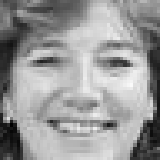

shape (1, 160, 160, 3)
TIME:  0.002395475999946939
[['18511.jpg', 2, 2.3237925], ['12546.jpg', 3, 2.4339726], ['16256.jpg', 3, 2.490593], ['4244.jpg', 6, 2.4917474], ['6323.jpg', 6, 2.4917474], ['13101.jpg', 3, 2.4921412], ['7793.jpg', 5, 2.5353255], ['18323.jpg', 4, 2.5595372], ['12648.jpg', 4, 2.562435], ['9986.jpg', 6, 2.6038268]]
f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Fear/18511.jpg
18511.jpg - 2.324


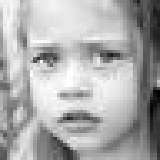

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/12546.jpg
12546.jpg - 2.434


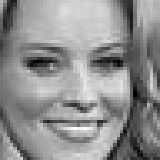

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/16256.jpg
16256.jpg - 2.491


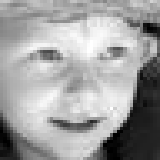

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Surprise/4244.jpg
4244.jpg - 2.492


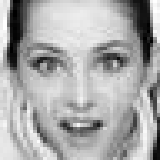

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Surprise/6323.jpg
6323.jpg - 2.492


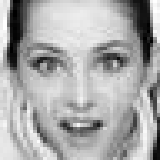

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/13101.jpg
13101.jpg - 2.492


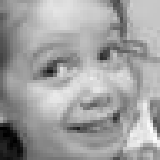

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Sad/7793.jpg
7793.jpg - 2.535


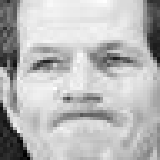

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Neutral/18323.jpg
18323.jpg - 2.560


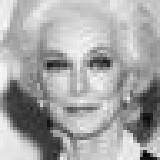

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Neutral/12648.jpg
12648.jpg - 2.562


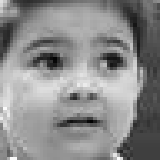

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Surprise/9986.jpg
9986.jpg - 2.604


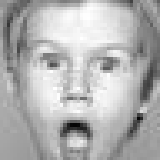

In [ ]:
#RETRIEVAL WITH THE PREDEFINED MODEL
query_facenet = load_image(QUERY_PATH)
query_extract = feature_extractor(facenet_model,query_facenet)
start_time = time.perf_counter()
results = LSHnormal.search(query_extract[0], 4, 4,10)
end_time = time.perf_counter()
print("TIME: ", end_time - start_time)
print(results)
labels,distances,ids = create_from_results(results)


for i in range(len(ids)):
  id = ids[i]
  distance = distances[i]
  label = labels[i]
  display_image(id,distance,label)





Query: 


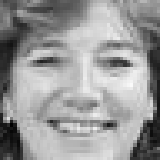

shape (1, 160, 160, 3)
TIME:  0.002110309000045163
[['10139.jpg', 3, 0.11368948221206665], ['25345.jpg', 3, 0.11690753698348999], ['9642.jpg', 3, 0.12231016159057617], ['8995.jpg', 3, 0.12952083349227905], ['3453.jpg', 3, 0.13486570119857788], ['22110.jpg', 3, 0.1423155665397644], ['16551.jpg', 3, 0.1531047224998474], ['22832.jpg', 3, 0.153123676776886], ['8411.jpg', 4, 0.1543567180633545], ['2438.jpg', 3, 0.168565571308136]]
f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/10139.jpg
10139.jpg - 0.114


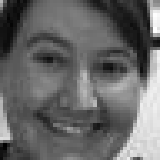

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/25345.jpg
25345.jpg - 0.117


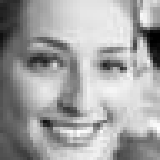

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/9642.jpg
9642.jpg - 0.122


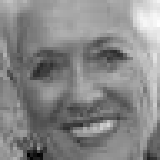

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/8995.jpg
8995.jpg - 0.130


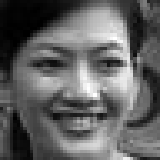

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/3453.jpg
3453.jpg - 0.135


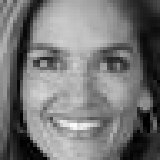

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/22110.jpg
22110.jpg - 0.142


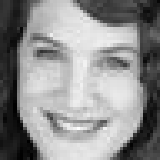

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/16551.jpg
16551.jpg - 0.153


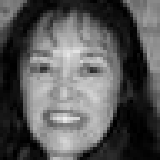

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/22832.jpg
22832.jpg - 0.153


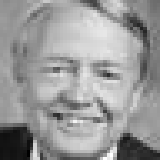

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Neutral/8411.jpg
8411.jpg - 0.154


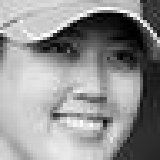

f /content/gdrive/MyDrive/progetto/dbs/dataset/Training/Happy/2438.jpg
2438.jpg - 0.169


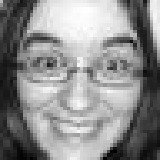

In [ ]:
#RETRIEVAL WITH THE FINE-TUNED MODEL
query_facenet = load_image(QUERY_PATH)
query_extract_tuned = feature_extractor(facenet_finetune,query_facenet)
start_time = time.perf_counter()
results_tuned = LSHtuned.search(query_extract_tuned[0], 5, 5,10)
end_time = time.perf_counter()
print("TIME: ", end_time - start_time)
print(results_tuned)
labels_tun,distances_tun,ids_tun = create_from_results(results_tuned)

for i in range(len(ids_tun)):
  id = ids_tun[i]
  distance = distances_tun[i]
  label = labels_tun[i]
  display_image(id,distance,label)

